## Logistic Regression on Amazon Food Reviews Dataset

In [1]:
#importing required Modules
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#getting data 
conn = sqlite3.connect('final.sqlite')
final_amazon = pd.read_sql_query("""
SELECT *
FROM Reviews
""", conn) 

In [4]:
def cleanpunc(sentence): 
    '''
    function to clean the word of any punctuation or special characters
    '''
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
def cleanhtml(sentence): 
    '''
    function to clean the word of any html-tags
    '''
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [3]:
#getting stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#from autocorrect import spell

In [31]:
#Cleaning sentances
import re
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
i=0
list_of_sent_clean=[]
for sent in final_amazon.CleanedTextBow.values:
    filtered_sentence=[]
    #sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            cleaned_words = cleaned_words.strip()
            if( (cleaned_words.isalpha()) & \
                (len(cleaned_words)>2)):
                tmp = reduce_lengthening(cleaned_words.lower())
                tmp = spell(tmp)
                tmp = lem.lemmatize(tmp)
                filtered_sentence.append(tmp)
            else:
                continue 
    list_of_sent_clean.append(' '.join(filtered_sentence))

In [9]:
#Cleaning summary text
import re
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
i=0
list_of_summary_clean=[]
for sent in final_amazon.Summary.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha() & \
                  (len(cleaned_words)>2)): 
                tmp = reduce_lengthening(cleaned_words.lower())
                tmp = spell(tmp)
                tmp = lem.lemmatize(tmp)
                filtered_sentence.append(tmp)
            else:
                continue 
    list_of_summary_clean.append(' '.join(filtered_sentence))

In [10]:
#concatinating summary text and total text
final_amazon['final_text']= list_of_summary_clean
final_amazon['final_text'] = final_amazon['final_text'] + ' ' + list_of_sent_clean

In [18]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
final_stem_text = []
for sent in final_amazon.final_text:
    stem_sent = []
    for w in sent.split():
        stem_sent.append(stemmer.stem(w))
    final_stem_text.append(' '.join(stem_sent))       

In [21]:
final_amazon.drop('CleanedText',axis =1,inplace=True)

In [22]:
final_amazon['final_stem_text'] = final_stem_text

In [4]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final_clean_LR.sqlite')
c=conn.cursor()
conn.text_factory = str
final_amazon.to_sql('Reviews_final', conn, flavor=None, schema=None,
             if_exists='replace', index=True, 
                    index_label=None, chunksize=None, dtype=None)

In [4]:
conn = sqlite3.connect('final_clean_LR.sqlite')
final_review = pd.read_sql_query("""
SELECT *
FROM Reviews_final
""", conn) 

In [5]:
#SORT by time for TBS
final_review = final_review.sort_values(by='Time')

In [6]:
final_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 23 to 345187
Data columns (total 15 columns):
level_0                   364171 non-null int64
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
CleanedTextBow            364171 non-null object
final_text                364171 non-null object
final_stem_text           364171 non-null object
dtypes: int64(6), object(9)
memory usage: 44.5+ MB


In [7]:
#changing lables to 1 or 0
final_review.Score = final_review.Score.apply(lambda x:
                     1 if x == 'positive' else 0)

In [8]:
#Converting to int8
final_review.HelpfulnessNumerator = final_review.\
                      HelpfulnessNumerator.astype(np.int8)
final_review.HelpfulnessDenominator = final_review.\
                      HelpfulnessDenominator.astype(np.int8)

In [9]:
#Splitting Dataframe for train and test
train_df = final_review.iloc[:round(final_review.shape[0]*0.70),:]
test_df = final_review.iloc[round(final_review.shape[0]*0.70):,:]

In [10]:
print(train_df.shape)
print(test_df.shape)

(254920, 15)
(109251, 15)


### Bag of Words:

In [34]:
#BoW with cleaned data and without stopwords
#simple cv for train data
#wit l2 regularization
scores_train = []
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.remove('not')
stop.remove('very')
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = count_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = count_vect.transform(X_test_cv['final_text'].values)

In [35]:
inv_lamda = [0.0001,0.0005,0.0008,0.001,0.005,0.01, 0.1, 1, 10, 100, 1000]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

0.0001 Train 0.8703290668220842 CV 0.8441864114231916 No of zeros in Weight vec 0
0.0005 Train 0.8983882898836609 CV 0.8818845127883258 No of zeros in Weight vec 0
0.0008 Train 0.9068054964022326 CV 0.892842198859773 No of zeros in Weight vec 0
0.001 Train 0.910599403734505 CV 0.8977718499921544 No of zeros in Weight vec 0
0.005 Train 0.9325334558741117 CV 0.9230477535435954 No of zeros in Weight vec 0
0.01 Train 0.9391910067023829 CV 0.9296903603744966 No of zeros in Weight vec 0
0.1 Train 0.9547981439555266 CV 0.93830744285789 No of zeros in Weight vec 0
1 Train 0.9685671695321781 CV 0.9377320989591506 No of zeros in Weight vec 0
10 Train 0.9744681804936002 CV 0.9345938595114808 No of zeros in Weight vec 0
100 Train 0.9695198493645065 CV 0.9365291071708771 No of zeros in Weight vec 0
1000 Train 0.9747147564502029 CV 0.934306187562111 No of zeros in Weight vec 0


it seems to be, if C is low i.e high regularization strength, training and test both scores are low and if c is high i.e low regularization strength, it is somewhat overfitting to the data. from above we can infer tat arout 0.01 and 0.1 value of C is better for the data.

In [19]:
inv_lamda = [0.005,0.008,0.02,0.06,0.08,0.1,0.13,0.18,0.20,0.25,0.28,0.33]
print('With l2 Regularization')
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                   'No of zeros in Weight vec',no_of_zero)

With l2 Regularization
0.005 Train 0.9325334558741117 CV 0.9230477535435954 No of zeros in Weight vec 0
0.008 Train 0.9371007150702741 CV 0.9278727966943878 No of zeros in Weight vec 0
0.02 Train 0.9444979937683531 CV 0.9337177676656729 No of zeros in Weight vec 0
0.06 Train 0.9516094685167336 CV 0.9373267430304932 No of zeros in Weight vec 0
0.08 Train 0.9533298962139383 CV 0.9380982268947121 No of zeros in Weight vec 0
0.1 Train 0.9547981439555266 CV 0.93830744285789 No of zeros in Weight vec 0
0.13 Train 0.9562271637040192 CV 0.9386604947957529 No of zeros in Weight vec 0
0.18 Train 0.9582277913519087 CV 0.9388697107589309 No of zeros in Weight vec 0
0.2 Train 0.9588778552374975 CV 0.938830482765835 No of zeros in Weight vec 0
0.25 Train 0.9600715070274147 CV 0.9387912547727392 No of zeros in Weight vec 0
0.28 Train 0.9607439869090583 CV 0.9388566347612323 No of zeros in Weight vec 0
0.33 Train 0.9618143507206742 CV 0.9386343428003556 No of zeros in Weight vec 0


In [29]:
inv_lamda = [0.005,0.008,0.02,0.06,0.08,0.1,0.13,0.18,0.20,0.25,0.28,0.33]
print('With l2 Regularization')
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,class_weight='balanced',n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                   'No of zeros in Weight vec',no_of_zero)

With l2 Regularization
0.005 Train 0.9107619197059021 CV 0.9005047335111669 No of zeros in Weight vec 0
0.008 Train 0.9157158548340095 CV 0.9043490768345624 No of zeros in Weight vec 0
0.02 Train 0.9236174934433211 CV 0.9106647837229981 No of zeros in Weight vec 0
0.06 Train 0.9323933558987694 CV 0.9157644228254616 No of zeros in Weight vec 0
0.08 Train 0.9345957275111519 CV 0.9167974266436529 No of zeros in Weight vec 0
0.1 Train 0.9365907511600278 CV 0.9177912024687483 No of zeros in Weight vec 0
0.13 Train 0.9383952388424379 CV 0.9186411423191589 No of zeros in Weight vec 0
0.18 Train 0.9411636143552039 CV 0.9198310581097338 No of zeros in Weight vec 0
0.2 Train 0.9418865302279706 CV 0.9199879700821173 No of zeros in Weight vec 0
0.25 Train 0.9436069579251755 CV 0.9204979339923636 No of zeros in Weight vec 0
0.28 Train 0.944481181771312 CV 0.9206417699670485 No of zeros in Weight vec 0
0.33 Train 0.9456748335612293 CV 0.921112505884199 No of zeros in Weight vec 0


In [20]:
#with l1 regularization
print('with l1 Regularization')
inv_lamda = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                 'No of zeros in Weight vec',no_of_zero)

with l1 Regularization
0.001 Train 0.8689392750666876 CV 0.8427349756786443 No of zeros in Weight vec 50505
0.01 Train 0.9205072739907197 CV 0.9104424917621214 No of zeros in Weight vec 50241
0.1 Train 0.9435509179350384 CV 0.9358491552905487 No of zeros in Weight vec 48945
1 Train 0.9629351505234135 CV 0.93792823892463 No of zeros in Weight vec 43334
10 Train 0.9828181390240075 CV 0.9250222291960877 No of zeros in Weight vec 33960
100 Train 0.9861525184371568 CV 0.9090041320152727 No of zeros in Weight vec 28292
1000 Train 0.9865840263612113 CV 0.9005962654950572 No of zeros in Weight vec 24702


In [22]:
inv_lamda = [0.005,0.008,0.02,0.06,0.08,0.1,0.13,0.18,0.20,0.25,0.28,0.33]
print('With l1 Regularization')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l1 Regularization
0.005 Train 0.9082177041536841 CV 0.8949082064961557 No of zeros in Weight vec 50369
0.008 Train 0.917055210598283 CV 0.9062189445054658 No of zeros in Weight vec 50294
0.02 Train 0.9293671964313734 CV 0.9214001778335688 No of zeros in Weight vec 50042
0.06 Train 0.939336710676739 CV 0.9322271039280297 No of zeros in Weight vec 49460
0.08 Train 0.9417800542467104 CV 0.9342669595690151 No of zeros in Weight vec 49179
0.1 Train 0.9435565219340522 CV 0.9358622312882473 No of zeros in Weight vec 48944
0.13 Train 0.945439465602654 CV 0.937091375071918 No of zeros in Weight vec 48618
0.18 Train 0.9479108291676941 CV 0.9379151629269313 No of zeros in Weight vec 48130
0.2 Train 0.9486169330434198 CV 0.9380197709085203 No of zeros in Weight vec 47942
0.25 Train 0.9502028647642958 CV 0.9381505308855066 No of zeros in Weight vec 47511
0.28 Train 0.9511275246015557 CV 0.9382943668601914 No of zeros in Weight vec 47271
0.33 Train 0.9525173163569524 CV 0.9384382028348763 No of

In [23]:
inv_lamda = [0.005,0.008,0.02,0.06,0.08,0.1,0.13,0.18,0.20,0.25,0.28,0.33]
print('With l1 Regularization')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,solver='saga',n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l1 Regularization
0.005 Train 0.9128466073389971 CV 0.9010408494168105 No of zeros in Weight vec 50365
0.008 Train 0.9209163659187196 CV 0.9106255557299022 No of zeros in Weight vec 50275
0.02 Train 0.9322084239313174 CV 0.924420733301951 No of zeros in Weight vec 49993
0.06 Train 0.9397626146017798 CV 0.9326063078612898 No of zeros in Weight vec 49234
0.08 Train 0.9410010983838066 CV 0.9338616036403578 No of zeros in Weight vec 48910
0.1 Train 0.9418304902378337 CV 0.9344500235367958 No of zeros in Weight vec 48577
0.13 Train 0.9427439420770662 CV 0.935038443433234 No of zeros in Weight vec 48130
0.18 Train 0.9434612539508193 CV 0.9359668392698363 No of zeros in Weight vec 47333
0.2 Train 0.9436798099123535 CV 0.9360714472514253 No of zeros in Weight vec 47121
0.25 Train 0.9441225258344355 CV 0.9364244991892882 No of zeros in Weight vec 46486
0.28 Train 0.9443130618009011 CV 0.9365552591662744 No of zeros in Weight vec 46099
0.33 Train 0.9445652417565175 CV 0.9367906271248496 No 

We can observe from above that, with l1 regularization if regularization strengt increses i.e C decreses, spaecity is also incesing and for some regularization strength we are getting similar test scores with l1 and l2 regularization for this data.

In [78]:
c = [0.001,0.005,0.008,0.01,0.02,0.06,0.08,0.1,
      0.13,0.18,0.20,0.25,0.28,0.33,0.45,0.55,0.65,1,3,10, 100, 1000] 
model_grid_bow = GridSearchCV(make_pipeline(CountVectorizer(stop_words=list(stop)),
                            LogisticRegression()),
                            param_grid={'logisticregression__C': c,
                                    'logisticregression__penalty':['l2','l1']},
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_bow.fit(train_df.final_text,train_df.Score)

In [64]:
dict_scores = []
idx = 0
for i in model_grid_bow.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_bow.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                               'Test_std','Train_score'])
scores_df_l1 = scores_df[scores_df.penality=='l1']
scores_df_l2 = scores_df[scores_df.penality=='l2']

In [65]:
#top10 cv scores with GridSearch CV
scores_df.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
18,l2,0.18,0.937680,0.002622,0.962179
20,l2,0.20,0.937624,0.002610,0.963065
22,l2,0.25,0.937602,0.002735,0.964801
24,l2,0.28,0.937590,0.002624,0.965629
26,l2,0.33,0.937512,0.002450,0.966780
28,l2,0.45,0.937305,0.002560,0.969136
16,l2,0.13,0.937292,0.002779,0.959622
29,l1,0.45,0.937154,0.002963,0.957555
30,l2,0.55,0.937063,0.002416,0.970623
31,l1,0.55,0.937024,0.002801,0.959865


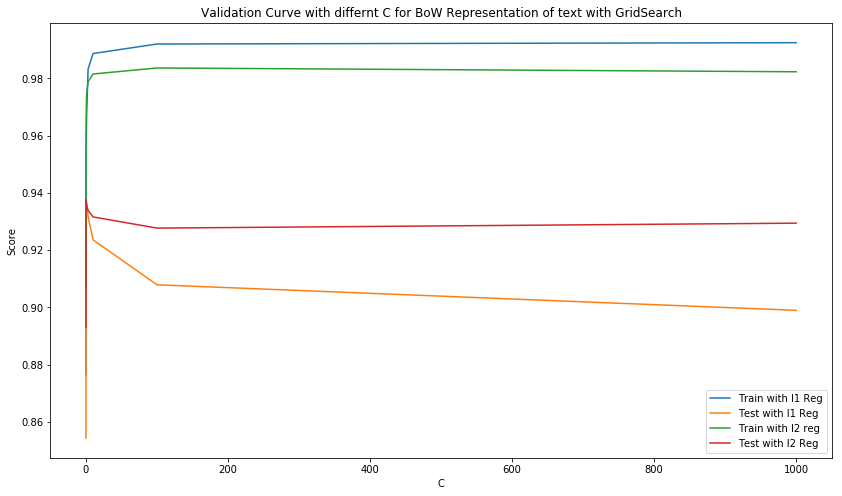

In [66]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for BoW Representation of text with GridSearch')
plt.legend()

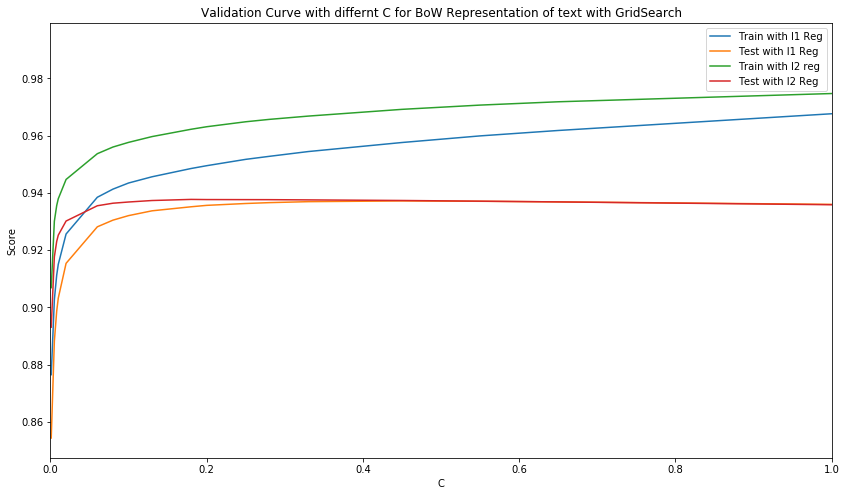

In [67]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
plt.xlim(0,1)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for BoW Representation of text with GridSearch')
plt.legend()

In [119]:
#random Search
model_random_bow = RandomizedSearchCV(
                        make_pipeline(CountVectorizer(stop_words=list(stop)),
                        LogisticRegression(n_jobs=-1)),
                    param_distributions={'logisticregression__C':uniform(loc=0,scale=1),
                            'logisticregression__penalty':['l2','l1']},n_iter=30,
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_bow.fit(train_df.final_text,train_df.Score)

In [69]:
dict_scores = []
idx = 0
for i in model_random_bow.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_bow.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                               'Test_std','Train_score'])
scores_df1_l1 = scores_df1[scores_df1.penality=='l1']
scores_df1_l2 = scores_df1[scores_df1.penality=='l2']

In [70]:
#top 10 scores from random Search
scores_df1.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
25,l2,0.386489,0.937391,0.002487,0.967984
6,l2,0.383442,0.937361,0.002472,0.967914
4,l2,0.437587,0.937292,0.002561,0.968928
16,l2,0.118274,0.937180,0.002852,0.958896
15,l1,0.520477,0.937149,0.002881,0.959204
2,l1,0.544883,0.937106,0.002794,0.959777
11,l1,0.368242,0.937067,0.002758,0.955453
0,l1,0.548814,0.937059,0.002797,0.959840
22,l2,0.568434,0.937054,0.002426,0.970869
8,l1,0.568045,0.937042,0.002765,0.960239


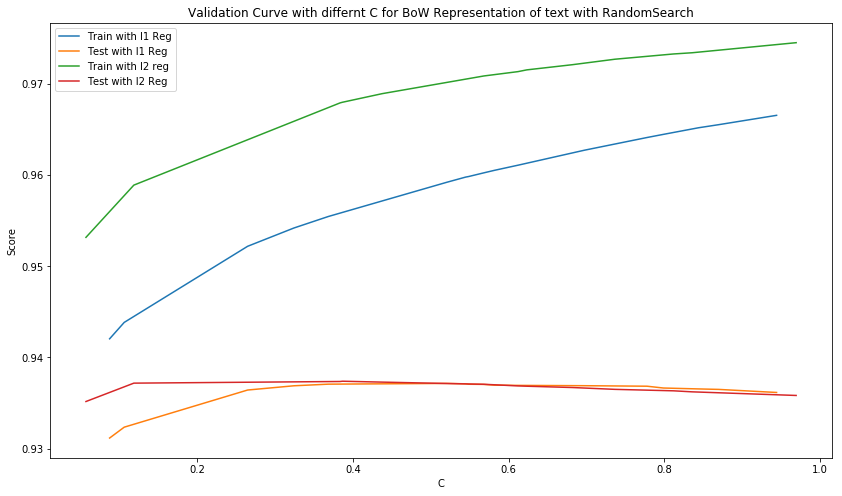

In [71]:
#plotting validation curve
scores_df1_l1.sort_values('C',inplace=True)
scores_df1_l2.sort_values('C',inplace=True)
plt.figure(figsize=(14,8))
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for BoW Representation of text with RandomSearch')
plt.legend()

* with Gridsearch and Randomsearch got best scores and for C in 0.4 to 1 wit la and l2 regularization we are getting maximum similar scores.
* For l1 regularization got best score at C = 0.5204774795512048 and cv mean score is 0.937149. and for l2 regularization got best score at 0.18 and cv mean score is 0.937680. 

In [127]:
##Test scores for L2 reg
#CountVectorizer for BoW
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.int8)
X_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)

model_l2 = LogisticRegression(penalty='l2',C=0.18,n_jobs=-1)
model_l2.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l2.predict(X_train)
#coeff
no_of_zero = sum(model_l2.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L2 Reg Best CV Score')
print('C' , 0.18)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L2 Reg Best CV Score
C 0.18
No of Zeros in Weigth Vec 0
Train Score 0.9559822689471207
Test Score 0.938087523226332
Test Precision 0.9520758807588076
Test Recall 0.9740163243578938
Test ConfusionMatrix [[14658  4421]
 [ 2343 87829]]


In [128]:
##Test scores for L1 reg
model_l1 = LogisticRegression(penalty='l1',C=0.5204774795512048,n_jobs=-1)
model_l1.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l1.predict(X_train)
#coeff
no_of_zero = sum(model_l1.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l1.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L1 Reg Best CV Score')
print('C' , 0.5204774795512048)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L1 Reg Best CV Score
C 0.5204774795512048
No of Zeros in Weigth Vec 51928
Train Score 0.9544759140122391
Test Score 0.9373918774198863
Test Precision 0.9522031690905144
Test Recall 0.9729849620724838
Test ConfusionMatrix [[14675  4404]
 [ 2436 87736]]


In [129]:
%%timeit
##Time for Predcting with L1 reg for 109251 instances 
test_list = model_l1.predict(X_test)

8.14 ms ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [130]:
%%timeit
##Time for Predcting with L2 reg for 109251 instances
test_list = model_l2.predict(X_test)

9.76 ms ± 17.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


L1 and L2 regularization is giving similar test scores and L1 regularization having 51928 zeros in the Weight vector.

###### Feature importance

In [12]:
##Perturbation test for Multicollinearity
#CountVectorizer for BoW
from scipy.stats import uniform
count_vect = CountVectorizer(stop_words=list(stop),dtype=np.float128)
X_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)

model_l2_bp = LogisticRegression(penalty='l2',C=0.18,n_jobs=-1)
model_l2_bp.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l2_bp.predict(X_train)
#coeff
Weight_bp = model_l2_bp.coef_
#Accuracy score
score_train_bp = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2_bp.predict(X_test)
#Accuracy score
score_test_bp = accuracy_score(test_df.Score,test_list)

X_train1 = X_train.copy()
X_train1[X_train1!=0] = uniform.rvs(loc=0,scale=0.01,size=1,random_state=0)
X_train_ap = X_train1+X_train
#test
X_test1 = X_test.copy()
X_test1[X_test1!=0] = uniform.rvs(loc=0,scale=0.01,size=1,random_state=0)
X_test_ap = X_test1+X_test

model_l2_ap = LogisticRegression(penalty='l2',C=0.18,n_jobs=-1)
model_l2_ap.fit(X_train_ap,train_df.Score)
#Predicting training data
train_list = model_l2_ap.predict(X_train_ap)
#coeff
Weight_ap = model_l2_ap.coef_
#Accuracy score
score_train_ap = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2_ap.predict(X_test_ap)
#Accuracy score
score_test_ap = accuracy_score(test_df.Score,test_list)

print('Test Score Befor Perturbation',score_test_bp)
print('Test Score After Perturbation',score_test_ap)

Test Score Befor Perturbation 0.938087523226332
Test Score After Perturbation 0.9380509102891507


In [13]:
#Weights before Perturbation
Weight_bp 

array([[ 0.11298219, -0.03456884, -0.04168738, ...,  0.00172645,
         0.0152829 ,  0.0006452 ]])

In [14]:
#Weights after Perturbation
Weight_ap

array([[ 0.11315245, -0.0345072 , -0.04175502, ...,  0.00175178,
         0.01529657,  0.00064797]])

In [15]:
#abs differnce of weights before and after 
diff_weight = []
Weight_bp = Weight_bp.ravel()
Weight_ap = Weight_ap.ravel()
for i in range(len(Weight_bp)):
    diff_weight.append(abs(Weight_bp[i]-Weight_ap[i]))

In [17]:
print('max', max(diff_weight))
print('min',min(diff_weight))
print('mean',np.mean(diff_weight))
print('median',np.median(diff_weight))
print('std',np.std(diff_weight))

max 0.010515558663356295
min 1.0760794589648268e-10
mean 0.0003665796941435793
median 0.00012369827941392103
std 0.0005590585279788438


We can observe not much diffence before and after perturbation, so not that much Multicollinear, so we can use weights vectors for feature importance

In [32]:
#feature importance
idx_neg = np.argsort(Weight_bp)
idx_pos = idx_neg[::-1]

In [33]:
features = np.array(count_vect.get_feature_names())

In [35]:
#top 50 negative features 
print(features[idx_neg[0:50]])

['disappointing' 'worst' 'yuck' 'mediocre' 'disappointment' 'terrible'
 'awful' 'undrinkable' 'horrible' 'tasteless' 'flavorless' 'sounded'
 'ruined' 'rip' 'overrated' 'threw' 'wheres' 'yuk' 'unacceptable'
 'deceptive' 'disappointed' 'lacking' 'ripoff' 'ick' 'ugh' 'cancelled'
 'bland' 'sorry' 'disgusting' 'died' 'skip' 'overpriced' 'concept' 'beech'
 'unfortunately' 'beware' 'poor' 'worse' 'stale' 'weak' 'unappealing' 'eh'
 'useless' 'overpowered' 'disliked' 'inedible' 'worthless' 'returning'
 'inconsistent' 'theory']


In [36]:
#top 50 positive features 
print(features[idx_pos[0:50]])

['pleasantly' 'yum' 'excellent' 'delicious' 'hooked' 'yummy' 'skeptical'
 'awesome' 'addicting' 'perfect' 'amazing' 'beat' 'addictive' 'pleased'
 'fantastic' 'best' 'addicted' 'wonderful' 'refreshing' 'delish' 'great'
 'fabulous' 'mm' 'delighted' 'terrific' 'worried' 'highly' 'satisfied'
 'resist' 'worry' 'yay' 'glad' 'heaven' 'smooth' 'complaint' 'thank'
 'disappoint' 'tasty' 'amazed' 'downside' 'outstanding' 'exceptional'
 'unique' 'welcome' 'perfectly' 'dumm' 'hesitate' 'surprisingly' 'happier'
 'happy']


### TF-IDF 

In [11]:
#TFIDF with (1,2) gram with cleaned data 
#simple cv for train data
#tfidf vec 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
final_counts_train = tf_idf_vect.fit_transform(
        X_train['final_text'].values)
#test
X_test = tf_idf_vect.transform(X_test_cv['final_text'].values)

In [54]:
inv_lamda = [0.0001,0.0005,0.0008,0.001,0.005,0.01, 0.1, 1, 10, 100, 1000]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',tol=0.000001,C=c,max_iter=150,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

0.0001 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.0005 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.0008 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.001 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.005 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.01 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 0
0.1 Train 0.9004897895137971 CV 0.8894685914535279 No of zeros in Weight vec 0
1 Train 0.963534778417879 CV 0.9441654898268738 No of zeros in Weight vec 0
10 Train 0.9975398444329874 CV 0.9546655159788692 No of zeros in Weight vec 0
100 Train 0.9999943960009863 CV 0.9558423557717454 No of zeros in Weight vec 0
1000 Train 0.9999943960009863 CV 0.9560254197395261 No of zeros in Weight vec 0


In [55]:
inv_lamda = [0.5,0.8,1.2,1.8,2,4,6,8]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

0.5 Train 0.9488130730088992 CV 0.9355353313457817 No of zeros in Weight vec 0
0.8 Train 0.9587993992513058 CV 0.94182488623882 No of zeros in Weight vec 0
1.2 Train 0.9669868418103158 CV 0.9457869135415032 No of zeros in Weight vec 0
1.8 Train 0.9747427764452713 CV 0.9486374810398034 No of zeros in Weight vec 0
2 Train 0.9767097800990787 CV 0.9491866729431455 No of zeros in Weight vec 0
4 Train 0.9883268700544708 CV 0.9522726084000209 No of zeros in Weight vec 0
6 Train 0.9932976171796194 CV 0.9532402322297191 No of zeros in Weight vec 0
8 Train 0.9960940126874538 CV 0.9540901720801297 No of zeros in Weight vec 0


In [12]:
inv_lamda = [0.0001,0.0005,0.0008,0.001,0.005,0.01, 0.1, 1, 10, 100, 1000]
print('with l1 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,max_iter=150,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

with l1 reg
0.0001 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 1826169
0.0005 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 1826169
0.0008 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 1826169
0.001 Train 0.8600121046378696 CV 0.8293451540352529 No of zeros in Weight vec 1826169
0.005 Train 0.860096164623075 CV 0.8294628380145405 No of zeros in Weight vec 1826166
0.01 Train 0.8624722602048822 CV 0.833660233275799 No of zeros in Weight vec 1826159
0.1 Train 0.922070789715541 CV 0.9145352790417909 No of zeros in Weight vec 1825947
1 Train 0.9561262917217727 CV 0.9489905329776662 No of zeros in Weight vec 1824338
10 Train 0.9976855484073435 CV 0.9526910403263769 No of zeros in Weight vec 1810900
100 Train 0.9999943960009863 CV 0.9503112087452272 No of zeros in Weight vec 1804811
1000 Train 0.9999943960009863 CV 0.952337988388514 No of zeros in Weight vec 1792072


In [13]:
inv_lamda = [0.5,0.8,1.2,1.8,2,4,6,8]
print('with l1 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,max_iter=150,n_jobs=-1)
    model.fit(final_counts_train,X_train.Score)
    #Predicting training data
    train_list = model.predict(final_counts_train)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

with l1 reg
0.5 Train 0.9481181771312008 CV 0.9425702181076416 No of zeros in Weight vec 1825181
0.8 Train 0.9537389881419381 CV 0.9469245253412836 No of zeros in Weight vec 1824677
1.2 Train 0.9580652753805116 CV 0.9505335007061039 No of zeros in Weight vec 1823993
1.8 Train 0.9633050144583175 CV 0.9529264082849521 No of zeros in Weight vec 1822818
2 Train 0.9646667862186457 CV 0.9534102201998013 No of zeros in Weight vec 1822406
4 Train 0.977034812041873 CV 0.9541555520686228 No of zeros in Weight vec 1817877
6 Train 0.9870547622783619 CV 0.9531487002458288 No of zeros in Weight vec 1814281
8 Train 0.9941494250297012 CV 0.9528871802918563 No of zeros in Weight vec 1812251


it seems to be l2 regularization cv scores are good with low regularization strength but it may overfits the training data.and l1 regulariztion is also giving similar scores as l2 and having maximum zeros i.e sparcity in weight vector. 

In [23]:
#grid search cv
c = [0.0001,0.0005,0.0008,0.001,0.005,0.01, 0.1, 1, 10, 100, 1000,1200,1500,2000,2500,5000]
c.extend([0.5,0.8,1.2,1.8,2,4,6,8])
c.sort()
model_grid_tfidf = GridSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                                    LogisticRegression(max_iter=150,n_jobs=-1)),
                             param_grid={'logisticregression__C': c,
                                'logisticregression__penalty':['l2','l1']},
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_tfidf.fit(train_df.final_text,train_df.Score)

In [30]:
dict_scores = []
idx = 0
for i in model_grid_tfidf.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_tfidf.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                              'Test_std','Train_score'])
scores_df_l1 = scores_df[scores_df.penality=='l1']
scores_df_l2 = scores_df[scores_df.penality=='l2']

In [35]:
#top 10 scores for gridsearch
scores_df.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
46,l2,5000.0,0.952589,0.003968,0.999992
44,l2,2500.0,0.952524,0.004036,0.999992
42,l2,2000.0,0.952412,0.003998,0.999991
40,l2,1500.0,0.952386,0.004088,0.999991
38,l2,1200.0,0.952317,0.004116,0.999992
36,l2,1000.0,0.952244,0.004157,0.999992
34,l2,100.0,0.951856,0.004494,0.999991
27,l1,4.0,0.951109,0.003841,0.975831
29,l1,6.0,0.950992,0.003561,0.986530
31,l1,8.0,0.950332,0.003694,0.993787


it seems like l2 reg is somewhats overfits the traindata than the l1.

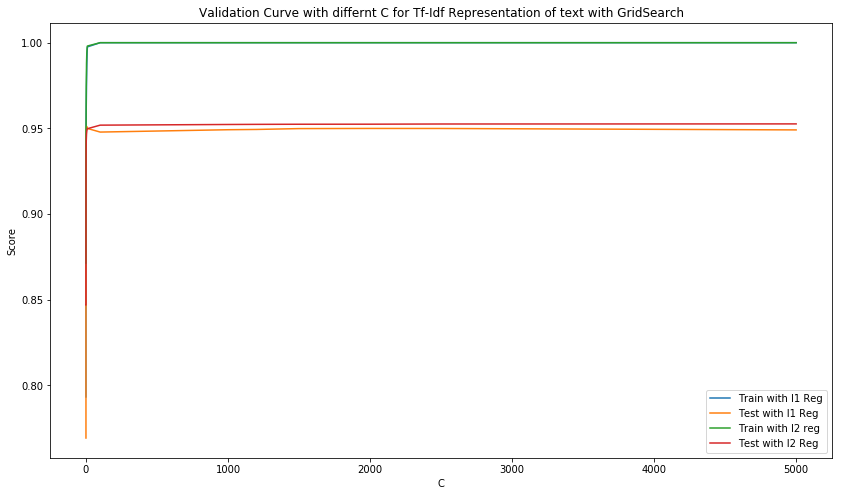

In [36]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for Tf-Idf Representation of text with GridSearch')
plt.legend()

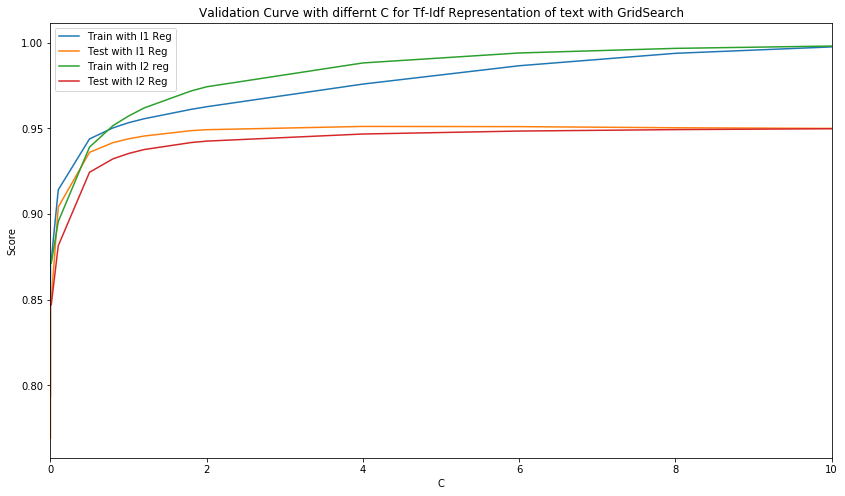

In [38]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
plt.xlim(0,10)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for Tf-Idf Representation of text with GridSearch')
plt.legend()

In [87]:
#random Search
from scipy.stats import uniform
model_random_tfidf = RandomizedSearchCV(make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                    LogisticRegression(max_iter=150,n_jobs=-1)),
                param_distributions={'logisticregression__C': uniform(loc=0,scale=25),
                              'logisticregression__penalty':['l2','l1']}, n_iter=40,
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidf.fit(train_df.final_text,train_df.Score)

In [89]:
dict_scores = []
idx = 0
for i in model_random_tfidf.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidf.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                               'Test_std','Train_score'])
scores_df1_l1 = scores_df1[scores_df1.penality=='l1']
scores_df1_l2 = scores_df1[scores_df1.penality=='l2']

In [90]:
#topscores with random search
scores_df1.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
2,l1,5.097182,0.951195,0.003519,0.982095
20,l1,5.475226,0.951152,0.003550,0.983991
31,l1,5.191613,0.951144,0.003559,0.982574
26,l2,24.599528,0.951044,0.004904,0.999900
6,l2,22.814445,0.950997,0.004949,0.999854
16,l2,22.323668,0.950941,0.004920,0.999839
37,l1,3.213526,0.950906,0.003933,0.971143
34,l2,20.536379,0.950867,0.004964,0.999772
24,l1,6.526549,0.950824,0.003593,0.988665
29,l2,19.399397,0.950785,0.005013,0.999711


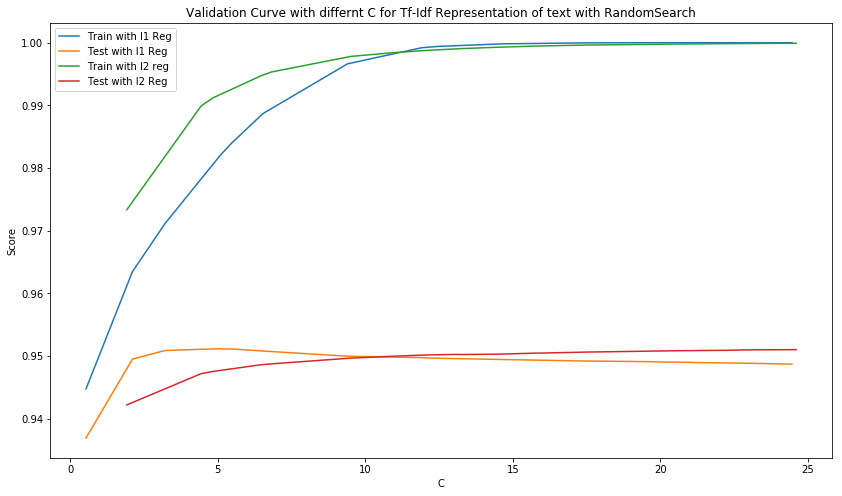

In [91]:
#plotting validation curve
scores_df1_l1.sort_values('C',inplace=True)
scores_df1_l2.sort_values('C',inplace=True)
plt.figure(figsize=(14,8))
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for Tf-Idf Representation of text with RandomSearch')
plt.legend()

from above cv scores it seems to be C = 5.0971819632421145 with cv mean score of 0.951195 for l1 and c = 5000 with cv mean score of 0.952589  for l2 reg are good 

In [93]:
##Test scores for L2 reg
#Tfidf
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tfidf_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = tfidf_vect.transform(test_df['final_text'].values)

model_l2 = LogisticRegression(penalty='l2',C=5000,n_jobs=-1)
model_l2.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l2.predict(X_train)
#coeff
no_of_zero = sum(model_l2.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L2 Reg Best CV Score')
print('C' , 5000)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L2 Reg Best CV Score
C 5000
No of Zeros in Weigth Vec 0
Train Score 0.9999960772006904
Test Score 0.9574740734638585
Test Precision 0.9672224285995237
Test Recall 0.9817459965399459
Test ConfusionMatrix [[16079  3000]
 [ 1646 88526]]


In [99]:
##Test scores for L1 reg
model_l1 = LogisticRegression(penalty='l1',C=5.0971819632421145,n_jobs=-1)
model_l1.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l1.predict(X_train)
#coeff
no_of_zero = sum(model_l1.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l1.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L1 Reg Best CV Score')
print('C' , 5.0971819632421145)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L1 Reg Best CV Score
C 5.0971819632421145
No of Zeros in Weigth Vec 2294526
Train Score 0.9834457869135415
Test Score 0.9561193947881484
Test Precision 0.9683584578588199
Test Recall 0.9788182584394268
Test ConfusionMatrix [[16195  2884]
 [ 1910 88262]]


###### Feature importance

In [15]:
##Perturbation test for Multicollinearity
##Test scores for L2 reg
#CountVectorizer for BoW
from scipy.stats import uniform
count_vect = TfidfVectorizer(ngram_range=(1,2),dtype=np.float128)
X_train = count_vect.fit_transform(
        train_df['final_text'].values)
#test
X_test = count_vect.transform(test_df['final_text'].values)

model_l2_bp = LogisticRegression(penalty='l2',C=5000,n_jobs=-1)
model_l2_bp.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l2_bp.predict(X_train)
#coeff
Weight_bp = model_l2_bp.coef_
#Accuracy score
score_train_bp = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2_bp.predict(X_test)
#Accuracy score
score_test_bp = accuracy_score(test_df.Score,test_list)

X_train1 = X_train.copy()
X_train1[X_train1!=0] = uniform.rvs(loc=0,scale=0.01,size=1,random_state=0)
X_train_ap = X_train1+X_train
#test
X_test1 = X_test.copy()
X_test1[X_test1!=0] = uniform.rvs(loc=0,scale=0.01,size=1,random_state=0)
X_test_ap = X_test1+X_test

model_l2_ap = LogisticRegression(penalty='l2',C=5000,n_jobs=-1)
model_l2_ap.fit(X_train_ap,train_df.Score)
#Predicting training data
train_list = model_l2_ap.predict(X_train_ap)
#coeff
Weight_ap = model_l2_ap.coef_
#Accuracy score
score_train_ap = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2_ap.predict(X_test_ap)
#Accuracy score
score_test_ap = accuracy_score(test_df.Score,test_list)

print('Test Score Befor Perturbation',score_test_bp)
print('Test Score After Perturbation',score_test_ap)

Test Score Befor Perturbation 0.9574740734638585
Test Score After Perturbation 0.9575381461039258


In [16]:
#weights before erturbation
Weight_bp

array([[1.94012741, 1.37505871, 0.0246249 , ..., 0.00397922, 0.00253746,
        0.00253746]])

In [17]:
#weights after perturbation
Weight_ap

array([[1.6783679 , 1.06450657, 0.02410681, ..., 0.00355471, 0.00212132,
        0.00212132]])

In [18]:
#abs differnce of weights before and after 
diff_weight = []
Weight_bp = Weight_bp.ravel()
Weight_ap = Weight_ap.ravel()
for i in range(len(Weight_bp)):
    diff_weight.append(abs(Weight_bp[i]-Weight_ap[i]))

In [19]:
print('max', max(diff_weight))
print('min',min(diff_weight))
print('mean',np.mean(diff_weight))
print('median',np.median(diff_weight))
print('std',np.std(diff_weight))

max 13.522010334506167
min 6.563040082317034e-09
mean 0.015819965071510282
median 0.0055242442050323325
std 0.037071090835323124


In [33]:
diff_weight = np.array(diff_weight)
sum(diff_weight>0.5)/len(diff_weight)

0.00030836153484355415

In [34]:
sum(diff_weight>1)/len(diff_weight)

0.00011173774717645643

Sum of them are having high differnce but difference > 0.5 are only 0.03083%. and we may neglect this and consider for feature importance 

In [29]:
#feature importance
idx_neg = np.argsort(Weight_bp)
idx_pos = idx_neg[::-1]

In [30]:
features = np.array(count_vect.get_feature_names())

In [31]:
#neg features
features[idx_neg[0:50]]

array(['not', 'disappointing', 'not worth', 'two star', 'terrible',
       'worst', 'not good', 'disappointed', 'horrible', 'yuck', 'awful',
       'disappointment', 'not recommend', 'not very', 'not great',
       'wanted like', 'very disappointed', 'not impressed',
       'economical bean', 'doesnt work', 'bland', 'tasteless',
       'not tasty', 'threw', 'nasty', 'worse', 'unfortunately', 'poor',
       'disgusting', 'weak', 'save your', 'stale', 'not buy', 'not happy',
       'least favorite', 'just doesnt', 'flavorless', 'didnt work',
       'gross', 'ruined', 'sorry', 'mediocre', 'not work', 'beware', 'me',
       'return', 'very little', 'dont recommend', 'definitely not', 'bad'],
      dtype='<U82')

In [32]:
#pos features
features[idx_pos[0:50]]

array(['great', 'delicious', 'good', 'excellent', 'best', 'not bad',
       'perfect', 'not disappointed', 'yummy', 'wonderful', 'awesome',
       'amazing', 'tasty', 'not too', 'love this', 'love', 'yum',
       'fantastic', 'favorite', 'highly recommend', 'nice', 'happy',
       'four star', 'not bitter', 'addictive', 'just right', 'just what',
       'pleased', 'better than', 'hooked', 'love these', 'loved',
       'addicted', 'pleasantly', 'refreshing', 'glad', 'you wont',
       'fabulous', 'easy', 'smooth', 'pleasantly surprised',
       'even better', 'heaven', 'beat', 'only complaint', 'fun',
       'skeptical', 'addicting', 'perfectly', 'love them'], dtype='<U82')

### Word2Vec

In [11]:
#importing
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

In [12]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [39]:
#word2vec model with 50 dim vector
w2v_model_50=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=8)
#word2vec model with 100 dim vector
w2v_model_100=gensim.models.Word2Vec(list_of_sent,min_count=5,size=100, workers=8)

In [62]:
w2v_model_300=gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=8)

In [64]:
#saving to disk
pickle.dump(w2v_model_50,open('w2v_model_nb_50.p','wb'))
pickle.dump(w2v_model_100,open('w2v_model_nb_100.p','wb'))
pickle.dump(w2v_model_300,open('w2v_model_nb_300.p','wb'))

In [13]:
#loading from disk
w2v_model_100 = pickle.load(open('w2v_model_nb_100.p','rb'))
w2v_model_50 = pickle.load(open('w2v_model_nb_50.p','rb'))
w2v_model_300 = pickle.load(open('w2v_model_nb_300.p','rb'))

### Avg Word2Vec

In [14]:
# the avg-w2v for each sentence/review is stored in this list
def avg_w2v(list_of_sent,model,d):
    '''
    Returns average of word vectors for 
    each sentance with dimension of model given
    '''
    sent_vectors = []
    for sent in list_of_sent: # for each review/sentence
        doc = [word for word in sent if word in model.wv.vocab]
        if doc:
            sent_vec = np.mean(model.wv[doc],axis=0)
        else:
            sent_vec = np.zeros(d)
        sent_vectors.append(sent_vec)
    return sent_vectors

In [92]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())

In [93]:
#avg word2vec for 
sent_vector_avgw2v_300 = avg_w2v(list_of_sent_train,w2v_model_300,300)

In [94]:
#stacking columns
train_avgw2v_300 = np.hstack((sent_vector_avgw2v_300,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
train_df_avgw2v_300 = pd.DataFrame(train_avgw2v_300,columns=column)

In [95]:
#CountVectorizer for BoW
X_train = train_df_avgw2v_300.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df_avgw2v_300.iloc[round(train_df.shape[0]*0.70):,:]
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train.drop('Score',axis=1))
X_test_cv_sc = scale.transform(X_test_cv.drop('Score',axis=1))

In [96]:
inv_lamda = [0.001,0.01,0.05,1,1.5,5,10,100,1000]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

0.001 Train 0.9389612427428212 CV 0.9316386840315916 No of zeros in Weight vec 0
0.01 Train 0.9431866579991481 CV 0.9351953554056175 No of zeros in Weight vec 0
0.05 Train 0.9440104458541615 CV 0.9354830273549872 No of zeros in Weight vec 0
1 Train 0.9441897738225998 CV 0.9357053193158638 No of zeros in Weight vec 0
1.5 Train 0.9441897738225998 CV 0.9356660913227679 No of zeros in Weight vec 0
5 Train 0.9441841698235861 CV 0.9357053193158638 No of zeros in Weight vec 0
10 Train 0.9442065858196409 CV 0.9356922433181651 No of zeros in Weight vec 0
100 Train 0.9441841698235861 CV 0.9357445473089597 No of zeros in Weight vec 0
1000 Train 0.9441785658245724 CV 0.9357445473089597 No of zeros in Weight vec 0


In [97]:
inv_lamda = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

1 Train 0.9441897738225998 CV 0.9357053193158638 No of zeros in Weight vec 0
1.5 Train 0.9441897738225998 CV 0.9356660913227679 No of zeros in Weight vec 0
2 Train 0.9441897738225998 CV 0.9356530153250693 No of zeros in Weight vec 0
2.5 Train 0.9441897738225998 CV 0.9356660913227679 No of zeros in Weight vec 0
3 Train 0.9442009818206272 CV 0.9356922433181651 No of zeros in Weight vec 0
3.5 Train 0.9442009818206272 CV 0.9356922433181651 No of zeros in Weight vec 0
4 Train 0.9442009818206272 CV 0.9356922433181651 No of zeros in Weight vec 0
4.5 Train 0.9442009818206272 CV 0.9356922433181651 No of zeros in Weight vec 0
5 Train 0.9441841698235861 CV 0.9357053193158638 No of zeros in Weight vec 0
5.5 Train 0.9442009818206272 CV 0.9356922433181651 No of zeros in Weight vec 0


In [98]:
inv_lamda = [0.8,15,20,30,40,50]
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

0.8 Train 0.9441729618255588 CV 0.9357053193158638 No of zeros in Weight vec 0
15 Train 0.9442065858196409 CV 0.9357053193158638 No of zeros in Weight vec 0
20 Train 0.9441953778216136 CV 0.9357053193158638 No of zeros in Weight vec 0
30 Train 0.9441953778216136 CV 0.9357183953135624 No of zeros in Weight vec 0
40 Train 0.9441953778216136 CV 0.935731471311261 No of zeros in Weight vec 0
50 Train 0.9441841698235861 CV 0.935731471311261 No of zeros in Weight vec 0


In [100]:
inv_lamda = [0.001,0.01,0.05,1,1.5,5,10,100,1000]
print('with l1 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

with l1 reg
0.001 Train 0.9218466297549932 CV 0.9093833359485328 No of zeros in Weight vec 212
0.01 Train 0.9419705902131761 CV 0.9328416758198651 No of zeros in Weight vec 82
0.05 Train 0.9437358499024904 CV 0.9351299754171243 No of zeros in Weight vec 27
1 Train 0.9441897738225998 CV 0.9356530153250693 No of zeros in Weight vec 0
1.5 Train 0.9441953778216136 CV 0.9356399393273707 No of zeros in Weight vec 1
5 Train 0.9441841698235861 CV 0.9357053193158638 No of zeros in Weight vec 0
10 Train 0.9441785658245724 CV 0.9356791673204665 No of zeros in Weight vec 0
100 Train 0.9441897738225998 CV 0.9357053193158638 No of zeros in Weight vec 0
1000 Train 0.9441841698235861 CV 0.9357053193158638 No of zeros in Weight vec 0


We can observe that C between 1 to 10 may give better cv score. and For this data we can observe that for l1 regularization for regularization stregth <1 is not giving any sparse data. 

In [11]:
#grid Search
c = [0.01,0.1,0.5,0.8,1,1.3,1.8,4,5,10,30,50,70,100,1000]
c.sort()
model_grid_avgw2v = GridSearchCV(make_pipeline(StandardScaler(),
                            LogisticRegression(max_iter=150,n_jobs=-1)),
                             param_grid={'logisticregression__C': c,
                            'logisticregression__penalty':['l2','l1']},
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_avgw2v.fit(train_df_avgw2v_300.drop('Score',axis=1),train_df_avgw2v_300.Score)

In [22]:
dict_scores = []
idx = 0
for i in model_grid_avgw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_avgw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                              'Test_std','Train_score'])
scores_df_l1 = scores_df[scores_df.penality=='l1']
scores_df_l2 = scores_df[scores_df.penality=='l2']

In [23]:
#best scores with grid search
scores_df.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
14,l2,4.0,0.938125,0.004009,0.947528
16,l2,5.0,0.938107,0.004017,0.947526
21,l1,30.0,0.938103,0.004001,0.947534
10,l2,1.3,0.938103,0.003968,0.947521
12,l2,1.8,0.938103,0.003987,0.947544
20,l2,30.0,0.938099,0.004019,0.947524
19,l1,10.0,0.938099,0.004021,0.947541
18,l2,10.0,0.938099,0.004010,0.947523
24,l2,70.0,0.938099,0.004021,0.947526
29,l1,1000.0,0.938099,0.004041,0.947535


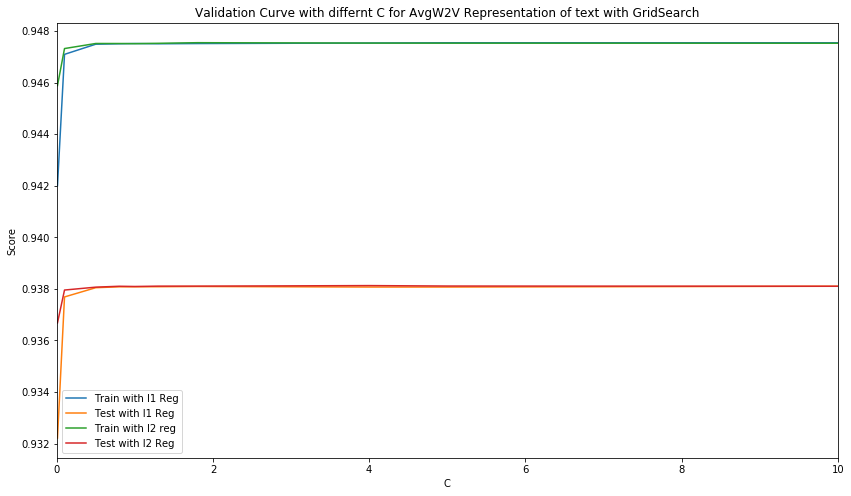

In [25]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
plt.xlim(0,10)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for AvgW2V Representation of text with GridSearch')
plt.legend()

In [39]:
#random Search
from scipy.stats import uniform
model_random_avgw2v = RandomizedSearchCV(make_pipeline(StandardScaler(),
                        LogisticRegression(max_iter=150,n_jobs=-1)), n_iter=40,
            param_distributions={'logisticregression__C': uniform(loc=0,scale=8),
                        'logisticregression__penalty':['l2','l1']},
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_avgw2v.fit(train_df_avgw2v_300.drop('Score',axis=1),train_df_avgw2v_300.Score)

In [42]:
dict_scores = []
idx = 0
for i in model_random_avgw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_avgw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                               'Test_std','Train_score'])
scores_df1_l1 = scores_df1[scores_df1.penality=='l1']
scores_df1_l2 = scores_df1[scores_df1.penality=='l2']

In [43]:
#best score wit random search
scores_df1.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
35,l1,6.430775,0.938120,0.004039,0.947535
8,l1,6.073376,0.938116,0.004036,0.947536
33,l2,4.382682,0.938116,0.004014,0.947524
31,l2,4.327571,0.938116,0.004012,0.947530
0,l2,2.590684,0.938112,0.004005,0.947532
18,l2,2.374378,0.938112,0.004005,0.947537
14,l1,6.050058,0.938112,0.004034,0.947531
39,l2,4.583649,0.938112,0.004017,0.947524
37,l2,2.087359,0.938107,0.003996,0.947543
28,l1,6.312730,0.938107,0.004033,0.947528


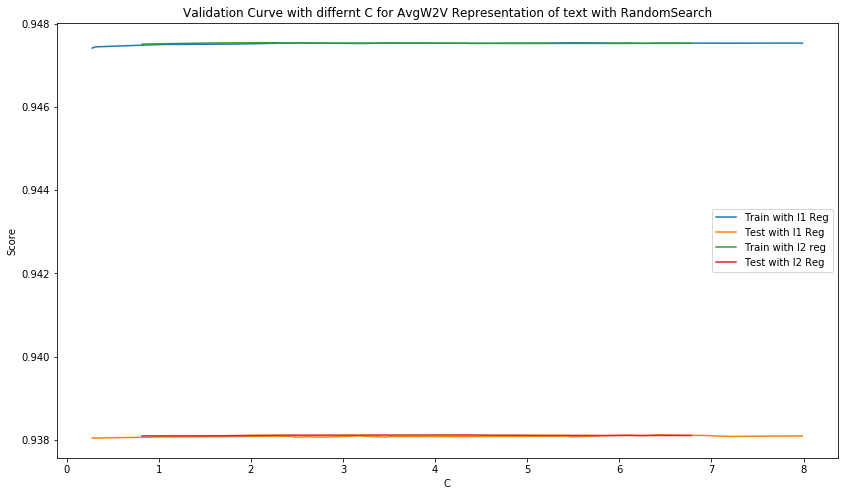

In [44]:
#plotting validation curve
scores_df1_l1.sort_values('C',inplace=True)
scores_df1_l2.sort_values('C',inplace=True)
plt.figure(figsize=(14,8))
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for AvgW2V Representation of text with RandomSearch')
plt.legend()

From 10 fold CV we can infer that, best cv score for L2 reg is at C = 4 with mean cv score of 0.938125. Best cv score for l1 reg is at C = 6.430775 with cv mean score of 0.938120

In [48]:
list_of_sent_train=[]
for sent in train_df.final_text.values:
    list_of_sent_train.append(sent.split())
vector_avgw2v_300_train = avg_w2v(list_of_sent_train,w2v_model_300,300)

list_of_sent_test=[]
for sent in test_df.final_text.values:
    list_of_sent_test.append(sent.split())
vector_avgw2v_300_test = avg_w2v(list_of_sent_test,w2v_model_300,300)

#stacking columns for train
train_avgw2v_300 = np.hstack((vector_avgw2v_300_train,
            train_df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
train_df_avgw2v  = pd.DataFrame(train_avgw2v_300,columns=column)

#stacking columns for test
test_avgw2v_300 = np.hstack((vector_avgw2v_300_test,
            test_df[['HelpfulnessNumerator','HelpfulnessDenominator','Score']]))
column = list(range(0,300))
column.extend(['HelpfulnessNumerator','HelpfulnessDenominator','Score'])
test_df_avgw2v  = pd.DataFrame(test_avgw2v_300,columns=column)

#scaling
scale = StandardScaler()
X_train = scale.fit_transform(train_df_avgw2v.drop('Score',axis=1))
X_test = scale.transform(test_df_avgw2v.drop('Score',axis=1))

In [50]:
##Test scores for L2 reg
model_l2 = LogisticRegression(penalty='l2',C=4,n_jobs=-1)
model_l2.fit(X_train,train_df_avgw2v.Score)
#Predicting training data
train_list = model_l2.predict(X_train)
#coeff
no_of_zero = sum(model_l2.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df_avgw2v.Score,train_list)
#predict test cv
test_list = model_l2.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df_avgw2v.Score,test_list)
#precision
test_precision = precision_score(test_df_avgw2v.Score,test_list)
#recall
test_recall = recall_score(test_df_avgw2v.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df_avgw2v.Score,test_list)
print('L2 Reg Best CV Score')
print('C' , 4)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L2 Reg Best CV Score
C 4
No of Zeros in Weigth Vec 0
Train Score 0.942566295308332
Test Score 0.9299319914691856
Test Precision 0.9389902644038942
Test Recall 0.9786962693519052
Test ConfusionMatrix [[13345  5734]
 [ 1921 88251]]


In [51]:
##Test scores for L1 reg
model_l1 = LogisticRegression(penalty='l1',C=6.430775,n_jobs=-1)
model_l1.fit(X_train,train_df_avgw2v.Score)
#Predicting training data
train_list = model_l1.predict(X_train)
#coeff
no_of_zero = sum(model_l1.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df_avgw2v.Score,train_list)
#predict test cv
test_list = model_l1.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df_avgw2v.Score,test_list)
#precision
test_precision = precision_score(test_df_avgw2v.Score,test_list)
#recall
test_recall = recall_score(test_df_avgw2v.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df_avgw2v.Score,test_list)
print('L1 Reg Best CV Score')
print('C' , 6.430775)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L1 Reg Best CV Score
C 6.430775
No of Zeros in Weigth Vec 0
Train Score 0.9425584497097128
Test Score 0.9298221526576416
Test Precision 0.9389170842776129
Test Recall 0.9786408197666682
Test ConfusionMatrix [[13338  5741]
 [ 1926 88246]]


#### Tf-Idf Weighted Word2Vec

In [49]:
import gensim
list_of_sent=[]
for sent in final_review.final_text.values:
    list_of_sent.append(sent.split())

In [50]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(final_review.final_text.values)

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class TfidfWeightedWord2Vec(BaseEstimator, TransformerMixin):
    '''
    Class for Tfidf Weighted Word2Vec Calculations
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = word2vec.vector_size
        self.tfidf = None

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer()
        tfidf.fit(X[:,0])
        self.tfidf = tfidf
        #print(self.word2vec.wv.vocab.keys())
        return self
    
    def tf_idf_W2V(self,feature_names,tf_idf_trans_arr,list_of_sent):
        '''
        tfidf weighted word2vec calculation
        '''
        import operator
        dict_tfidf = {k: v for v, k in enumerate(feature_names)}
        sent_vectors = []
        i = 0
        for sent in list_of_sent: # for each review/sentence
            doc = [word for word in sent if word in self.word2vec.wv.vocab.keys()]
            if doc:
                #itemgetter
                f = operator.itemgetter(*doc)
                try:
                    #itemgetter from dict
                    final = f(dict_tfidf)
                    final = tf_idf_trans_arr[i,final]
                    #converting to dense
                    final = final.toarray()
                    #converting to diagnol matrix for multiplication
                    final= np.diag(final[0])
                    sent_vec = np.dot(final,np.array(self.word2vec.wv[doc]))
                    #tfidf weighted word to vec
                    sent_vec = np.sum(sent_vec,axis=0) / np.sum(final)
                except:
                    sent_vec = np.zeros(self.dim)             
            else:
                sent_vec = np.zeros(self.dim)
            sent_vectors.append(sent_vec)
            i = i+1
        return sent_vectors

    def transform(self, X):
        #transform data
        tf_idf_trans_arr = self.tfidf.transform(X[:,0])
        feature_names = self.tfidf.get_feature_names()
        list_of_sent = []
        for sent in X[:,0]:
            list_of_sent.append(sent.split())
        temp_vec = self.tf_idf_W2V(feature_names,tf_idf_trans_arr,list_of_sent)
        temp_vec= np.hstack((temp_vec,X[:,[1,2]]))
        return temp_vec

In [55]:
#instance of class above for testing
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)

In [56]:
tfidfvect_w2v.fit(final_review[['final_text','HelpfulnessNumerator',
                                'HelpfulnessDenominator']].values)

TfidfWeightedWord2Vec(word2vec=<gensim.models.word2vec.Word2Vec object at 0x150ca3b8de80>)

In [57]:
x_trans = tfidfvect_w2v.transform(final_review[['final_text',
                        'HelpfulnessNumerator','HelpfulnessDenominator']].values)

In [60]:
len(x_trans[0])

302

In [18]:
# For simple cv
#Train data
X_train = train_df.iloc[:round(train_df.shape[0]*0.70),:]
X_test_cv = train_df.iloc[round(train_df.shape[0]*0.70):,:]
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(X_train[['final_text','HelpfulnessNumerator',
                           'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(X_train[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(X_test_cv[['final_text',
                 'HelpfulnessNumerator','HelpfulnessDenominator']].values)

In [19]:
#scaling the data
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train_tfw2v)
X_test_cv_sc = scale.transform(X_cv_tfw2v)

In [69]:
inv_lamda = [0.001,0.01,0.05,1,1.5,5,10,100,1000]
print('With l2 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l2 reg
0.001 Train 0.9189773822599807 CV 0.9030153250693028 No of zeros in Weight vec 0
0.01 Train 0.9249736612046356 CV 0.9083895601234374 No of zeros in Weight vec 0
0.05 Train 0.926425096949183 CV 0.9091218159945604 No of zeros in Weight vec 0
1 Train 0.9266996929008541 CV 0.9094356399393274 No of zeros in Weight vec 0
1.5 Train 0.9267052968998677 CV 0.9094356399393274 No of zeros in Weight vec 0
5 Train 0.9267277128959225 CV 0.9094617919347247 No of zeros in Weight vec 0
10 Train 0.9267221088969089 CV 0.9094617919347247 No of zeros in Weight vec 0
100 Train 0.9267221088969089 CV 0.9094748679324233 No of zeros in Weight vec 0
1000 Train 0.9267221088969089 CV 0.9094748679324233 No of zeros in Weight vec 0


In [70]:
inv_lamda = [3,5,10,20,30,50,70,100,500,1000]
print('With l2 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l2',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l2 reg
3 Train 0.9267277128959225 CV 0.9094617919347247 No of zeros in Weight vec 0
5 Train 0.9267277128959225 CV 0.9094617919347247 No of zeros in Weight vec 0
10 Train 0.9267221088969089 CV 0.9094617919347247 No of zeros in Weight vec 0
20 Train 0.9267221088969089 CV 0.9094617919347247 No of zeros in Weight vec 0
30 Train 0.9267277128959225 CV 0.9094748679324233 No of zeros in Weight vec 0
50 Train 0.9267221088969089 CV 0.9094748679324233 No of zeros in Weight vec 0
70 Train 0.9267277128959225 CV 0.9094748679324233 No of zeros in Weight vec 0
100 Train 0.9267221088969089 CV 0.9094748679324233 No of zeros in Weight vec 0
500 Train 0.9267277128959225 CV 0.9094748679324233 No of zeros in Weight vec 0
1000 Train 0.9267221088969089 CV 0.9094748679324233 No of zeros in Weight vec 0


In [20]:
inv_lamda = [0.001,0.01,0.05,1,1.5,5,10,100,1000]
print('With l1 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l1 reg
0.001 Train 0.9049561767277129 CV 0.8835320884983524 No of zeros in Weight vec 211
0.01 Train 0.9241498733496223 CV 0.906454312464041 No of zeros in Weight vec 85
0.05 Train 0.9263634529600323 CV 0.9091479679899577 No of zeros in Weight vec 19
1 Train 0.9266604649077582 CV 0.9093702599508342 No of zeros in Weight vec 2
1.5 Train 0.9266884849028266 CV 0.9093964119462314 No of zeros in Weight vec 2
5 Train 0.926682880903813 CV 0.9094225639416288 No of zeros in Weight vec 0
10 Train 0.9266996929008541 CV 0.9094225639416288 No of zeros in Weight vec 0
100 Train 0.9267165048978951 CV 0.909448715937026 No of zeros in Weight vec 0
1000 Train 0.9267277128959225 CV 0.9094617919347247 No of zeros in Weight vec 0


In [21]:
inv_lamda = [0.5,0.8,3,5,10,20,30,50,70,100,500,1000]
print('With l1 reg')
for c in inv_lamda:
    model = LogisticRegression(penalty='l1',C=c,max_iter=150,n_jobs=-1)
    model.fit(X_train_sc,X_train.Score)
    #Predicting training data
    train_list = model.predict(X_train_sc)
    #coeff
    no_of_zero = sum(model.coef_.ravel()==0)
    #Accuracy score
    score_train = accuracy_score(X_train.Score,train_list)
    #predict test cv
    test_list = model.predict(X_test_cv_sc)
    #Accuracy score
    score_test = accuracy_score(X_test_cv.Score,test_list)
    print(c , 'Train',score_train,'CV',score_test,
                    'No of zeros in Weight vec',no_of_zero)

With l1 reg
0.5 Train 0.9266156329156486 CV 0.9093179559600397 No of zeros in Weight vec 3
0.8 Train 0.9266380489117034 CV 0.9093310319577383 No of zeros in Weight vec 2
3 Train 0.926682880903813 CV 0.9094094879439302 No of zeros in Weight vec 0
5 Train 0.926682880903813 CV 0.9094225639416288 No of zeros in Weight vec 0
10 Train 0.9267052968998677 CV 0.9094225639416288 No of zeros in Weight vec 0
20 Train 0.9267052968998677 CV 0.9094356399393274 No of zeros in Weight vec 0
30 Train 0.9267052968998677 CV 0.9094356399393274 No of zeros in Weight vec 0
50 Train 0.9267052968998677 CV 0.909448715937026 No of zeros in Weight vec 0
70 Train 0.9267221088969089 CV 0.909448715937026 No of zeros in Weight vec 0
100 Train 0.9267052968998677 CV 0.909448715937026 No of zeros in Weight vec 0
500 Train 0.9267165048978951 CV 0.9094356399393274 No of zeros in Weight vec 0
1000 Train 0.9267109008988814 CV 0.909448715937026 No of zeros in Weight vec 0


In [52]:
c = [0.01, 0.1, 1, 10, 100,1000,2500]
c.extend([0.5,0.8,1.3,1.8,4,6,8])
c.sort()
model_grid_tfidfw2v = GridSearchCV(make_pipeline(TfidfWeightedWord2Vec(w2v_model_300),
                        StandardScaler(),LogisticRegression(max_iter=150,n_jobs=-1)),
                        param_grid={'logisticregression__C': c,
                            'logisticregression__penalty':['l2','l1']},
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_grid_tfidfw2v.fit(train_df[['final_text','HelpfulnessNumerator',
                                  'HelpfulnessDenominator']].values,train_df.Score)

In [55]:
dict_scores = []
idx = 0
for i in model_grid_tfidfw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_grid_tfidfw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                              'Test_std','Train_score'])
scores_df_l1 = scores_df[scores_df.penality=='l1']
scores_df_l2 = scores_df[scores_df.penality=='l2']

In [62]:
#top scores
scores_df.sort_values('Test_score',ascending=False).head(10)

,penality,C,Test_score,Test_std,Train_score
14,l2,4.0,0.914779,0.006225,0.931710
20,l2,10.0,0.914779,0.006234,0.931718
18,l2,8.0,0.914779,0.006234,0.931717
16,l2,6.0,0.914775,0.006225,0.931712
26,l2,2500.0,0.914771,0.006217,0.931728
24,l2,1000.0,0.914771,0.006217,0.931729
22,l2,100.0,0.914771,0.006217,0.931728
25,l1,1000.0,0.914767,0.006228,0.931708
23,l1,100.0,0.914767,0.006228,0.931712
21,l1,10.0,0.914762,0.006211,0.931701


In [63]:
#best scores with l1 reg
scores_df_l1.sort_values('Test_score',ascending=False).head(5)

,penality,C,Test_score,Test_std,Train_score
23,l1,100.0,0.914767,0.006228,0.931712
25,l1,1000.0,0.914767,0.006228,0.931708
21,l1,10.0,0.914762,0.006211,0.931701
27,l1,2500.0,0.914762,0.006219,0.931708
5,l1,0.5,0.914758,0.006326,0.931644


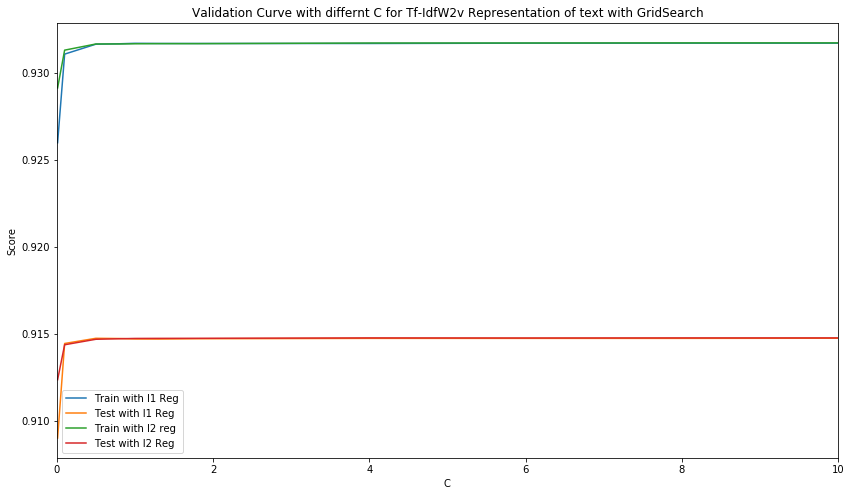

In [59]:
#plotting validation curve
plt.figure(figsize=(14,8))
plt.plot(scores_df_l1.C,
         scores_df_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df_l1.C,
         scores_df_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df_l2.C,
         scores_df_l2.Test_score,label='Test with l2 Reg')
plt.xlim(0,10)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for Tf-IdfW2v Representation of text with GridSearch')
plt.legend()

In [25]:
model_random_tfidfw2v = RandomizedSearchCV(
               make_pipeline(TfidfWeightedWord2Vec(w2v_model_300),StandardScaler(),
                LogisticRegression(max_iter=150,n_jobs=-1)),
                param_distributions={'logisticregression__C': uniform(loc=0,scale=5),
                'logisticregression__penalty':['l2','l1']},n_iter=10,
                            cv=TimeSeriesSplit(n_splits=10),n_jobs=-1)
model_random_tfidfw2v.fit(train_df[['final_text','HelpfulnessNumerator',
                                'HelpfulnessDenominator']].values,train_df.Score)

In [29]:
dict_scores = []
idx = 0
for i in model_random_tfidfw2v.grid_scores_:
    dict_score = []
    dict_score.append(i[0]['logisticregression__penalty'])
    dict_score.append(i[0]['logisticregression__C'])
    dict_score.append(i[1])
    dict_score.append(i[2].std())
    dict_score.append(model_random_tfidfw2v.cv_results_['mean_train_score'][idx])
    dict_scores.append(dict_score)
    idx = idx + 1
scores_df1 = pd.DataFrame(dict_scores,columns=['penality','C','Test_score',
                                               'Test_std','Train_score'])
scores_df1_l1 = scores_df1[scores_df1.penality=='l1']
scores_df1_l2 = scores_df1[scores_df1.penality=='l2']

In [32]:
scores_df1.sort_values('Test_score',ascending=False).head(5)

,penality,C,Test_score,Test_std,Train_score
5,l2,3.987496,0.914775,0.006225,0.931711
4,l1,3.928565,0.914767,0.006225,0.931691
1,l1,4.062778,0.914762,0.006227,0.931695
3,l2,3.222559,0.914762,0.006220,0.931706
7,l1,4.517030,0.914762,0.006215,0.931686


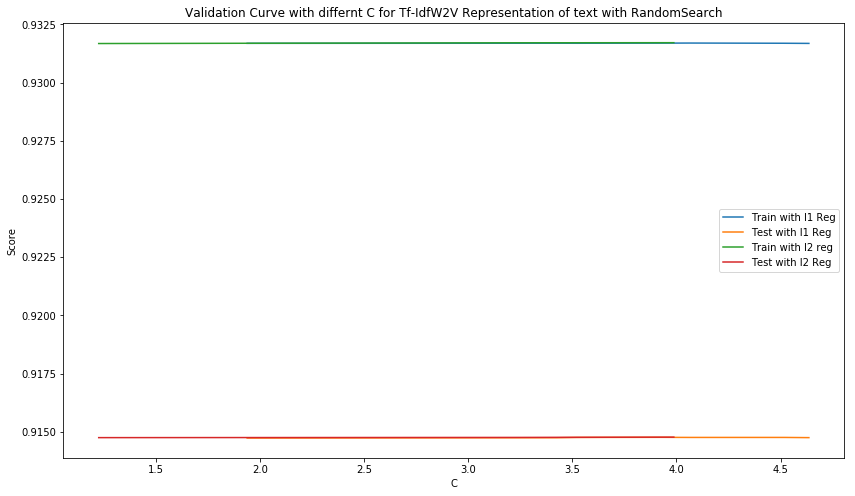

In [30]:
#plotting validation curve
scores_df1_l1.sort_values('C',inplace=True)
scores_df1_l2.sort_values('C',inplace=True)
plt.figure(figsize=(14,8))
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Train_score,label='Train with l1 Reg')
plt.plot(scores_df1_l1.C,
         scores_df1_l1.Test_score,label='Test with l1 Reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Train_score,label='Train with l2 reg')
plt.plot(scores_df1_l2.C,
         scores_df1_l2.Test_score,label='Test with l2 Reg')
#plt.xlim(0,5)
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve with differnt C for Tf-IdfW2V Representation of text with RandomSearch')
plt.legend()

Best cv score for l2 reg is at C  = 4.0	and mean cv score for 10 fold cv is 0.914779. Best cv score for l1 reg is at C = 3.987496 and mean cv score for 10 fold cv is 0.914775

In [39]:
w2v_model_300 = pickle.load(open('w2v_model_nb_300.p','rb'))
# For simple cv
#transforming to tfidf weighted word2vec
tfidfvect_w2v = TfidfWeightedWord2Vec(w2v_model_300)
tfidfvect_w2v.fit(train_df[['final_text','HelpfulnessNumerator',
                            'HelpfulnessDenominator']].values)
X_train_tfw2v = tfidfvect_w2v.transform(train_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
X_cv_tfw2v = tfidfvect_w2v.transform(test_df[['final_text',
                'HelpfulnessNumerator','HelpfulnessDenominator']].values)
scale = StandardScaler()
X_train = scale.fit_transform(X_train_tfw2v)
X_test = scale.transform(X_cv_tfw2v)

In [40]:
##Test scores for L2 reg
model_l2 = LogisticRegression(penalty='l2',C=4,n_jobs=-1)
model_l2.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l2.predict(X_train)
#coeff
no_of_zero = sum(model_l2.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l2.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L2 Reg Best CV Score')
print('C' , 4)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L2 Reg Best CV Score
C 4
No of Zeros in Weigth Vec 0
Train Score 0.9233445786913541
Test Score 0.9028933373607564
Test Precision 0.9079191575320693
Test Recall 0.981934525129752
Test ConfusionMatrix [[10099  8980]
 [ 1629 88543]]


In [41]:
##Test scores for L2 reg
model_l1 = LogisticRegression(penalty='l1',C=3.987496,n_jobs=-1)
model_l1.fit(X_train,train_df.Score)
#Predicting training data
train_list = model_l1.predict(X_train)
#coeff
no_of_zero = sum(model_l1.coef_.ravel()==0)
#Accuracy score
score_train = accuracy_score(train_df.Score,train_list)
#predict test cv
test_list = model_l1.predict(X_test)
#Accuracy score
score_test = accuracy_score(test_df.Score,test_list)
#precision
test_precision = precision_score(test_df.Score,test_list)
#recall
test_recall = recall_score(test_df.Score,test_list)
#confusion matrix
confusion_matrix_test = confusion_matrix(test_df.Score,test_list)
print('L1 Reg Best CV Score')
print('C' , 3.987496)
print('No of Zeros in Weigth Vec',no_of_zero)
print('Train Score', score_train)
print('Test Score',score_test)
print('Test Precision',test_precision)
print('Test Recall',test_recall)
print('Test ConfusionMatrix',confusion_matrix_test)

L1 Reg Best CV Score
C 3.987496
No of Zeros in Weigth Vec 0
Train Score 0.9233406558920446
Test Score 0.9028475711892797
Test Precision 0.9078809753296557
Test Recall 0.9819234352127046
Test ConfusionMatrix [[10095  8984]
 [ 1630 88542]]


#### Conclusions :  
1.  For BoW representation with l2 reg, got best cv score at C = 0.18 and mean cv score is 0.937680.
    * Train Score `0.9559822689471207` 
    * Test Score `0.938087523226332`
    * Test Precision `0.9520758807588076`
    * Test Recall `0.9740163243578938`
    * No of Zeros in Weigth Vec `0`
    * Test ConfusionMatrix
   \begin{equation}
   \begin{bmatrix}
    & 14658 & 4421 &  \\
    & 2343 & 87829 & 
  \end{bmatrix}
  \end{equation}
<br>
2. For BoW representation with l1 reg, got best score at C = 0.5204774795512048 and cv mean score is 0.937149
    *  Train Score `0.9544759140122391`
    *  Test Score `0.9373918774198863`
    *  Test Precision `0.9522031690905144`
    *  Test Recall `0.9729849620724838`
    *  No of Zeros in Weigth Vec `51928`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 14675 & 4404 &  \\
    & 2436 & 87736 & 
    \end{bmatrix}
    \end{equation}
<br>
3. For Tf-Idf representation with l2 reg, got best score at c = 5000 with cv mean score of 0.952589
    *  Train Score `0.9999960772006904`
    *  Test Score `0.9574740734638585`
    *  Test Precision `0.9672224285995237`
    *  Test Recall `0.9817459965399459`
    *  No of Zeros in Weigth Vec `0`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 16079 & 3000 &  \\
    & 1626 & 88526 & 
    \end{bmatrix}
    \end{equation}
<br>
4. For Tf-Idf representation with l1 reg, got best score at C = 5.0971819632421145 with cv mean score of 0.951195
    *  Train Score `0.9834457869135415`
    *  Test Score `0.9561193947881484`
    *  Test Precision `0.9683584578588199`
    *  Test Recall `0.9788182584394268`
    *  No of Zeros in Weigth Vec `2294526`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 16195 & 2884 &  \\
    & 1910 & 88262 & 
    \end{bmatrix}
    \end{equation}
<br>
5. For AvgW2V representation with l2 reg, got best score at C = 4 with mean cv score of 0.938125
    *  Train Score `0.942566295308332`
    *  Test Score `0.9299319914691856`
    *  Test Precision `0.9389902644038942`
    *  Test Recall `0.9786962693519052`
    *  No of Zeros in Weigth Vec `0`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 13345 & 5734 &  \\
    & 1921 & 88251 & 
    \end{bmatrix}
    \end{equation}
<br>
6. For AvgW2V  representation with l1 reg, got best score at C = 6.430775 with cv mean score of 0.938120
    *  Train Score `0.9425584497097128`
    *  Test Score `0.9298221526576416`
    *  Test Precision `0.9389170842776129`
    *  Test Recall `0.9786408197666682`
    *  No of Zeros in Weigth Vec `0`
    *  Test ConfusionMatrix
    \begin{equation}
        \begin{bmatrix}
        & 13338 & 5741 &  \\
        & 1926 & 88246 & 
        \end{bmatrix}
    \end{equation}
<br>
7. For TfIdf-W2V representation with l2 reg, got best score at C = 4.0 and mean cv score is 0.914779. 
    *  Train Score `0.9233445786913541`
    *  Test Score `0.9028933373607564`
    *  Test Precision `0.9079191575320693`
    *  Test Recall `0.981934525129752`
    *  No of Zeros in Weigth Vec `0`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 10099 & 8980 &  \\
    & 1629 & 88543 & 
    \end{bmatrix}
    \end{equation}
<br>
8. For TfIdf-W2V  representation with l1 reg, got best score at C = 3.987496 and mean cv score is 0.914775
    *  Train Score `0.9233406558920446`
    *  Test Score `0.9028475711892797`
    *  Test Precision `0.9078809753296557`
    *  Test Recall `0.9819234352127046`
    *  No of Zeros in Weigth Vec `0`
    *  Test ConfusionMatrix
    \begin{equation}
    \begin{bmatrix}
    & 10095 & 8984 &  \\
    & 1630 & 88542 & 
    \end{bmatrix}
    \end{equation}
<br>
9. best accuracy model is TF-Idf Representation with l1 regularization. best Precision model is Tf-Idf Represenataton with L1 regularization.Best recall model is Tf-Idf Weighted W2V wit l1 reguarization and Tf-Idf with l2 reg.